In [1]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\f

In [2]:
import os
import time

In [3]:
RANDOM_SEED = 123
IMAGE_SIZE = 224
EPOCHS = 100

In [4]:
TRAIN_CROP_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri_cropped', 'TRAIN')
TEST_CROP_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri_cropped', 'TEST')
VALIDATION_CROP_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri_cropped', 'VALIDATION')

MODEL_WEIGHT = os.path.sep.join(['result', 'model', 'brain_tumor_model.h5'])
MODEL_LABEL = os.path.sep.join(['result', 'model', 'brain_tumor_model.txt'])
MODEL_PLOT = os.path.sep.join(['result', 'model'])

# <a id='cnn'># CNN Model</a>
---

## <a id='aug'>## Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_CROP_PATH,
    color_mode='rgb',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VALIDATION_CROP_PATH,
    color_mode='rgb',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=16,
    class_mode='categorical',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## <a id='build'>## Model Building</a>

In [7]:
# load model
vgg_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)
)

for layer in vgg_model.layers:
    layer.trainable = False
        
x = vgg_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# instantiate new model
model = Model(inputs=vgg_model.input, outputs=predictions, name='brain_tumor_model')

# optimizer
lr = 1e-4
opt=Adam(learning_rate=lr)

# compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt, 
    metrics=['accuracy']
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001E445EE0388> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E445EE0E08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E444555208> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001E445F4BBC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E445F648C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E445FA3988> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001E445FCFE88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E446007C48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E446018B08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001E446046F08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001E44609DD48> False
<tensorflow.python.

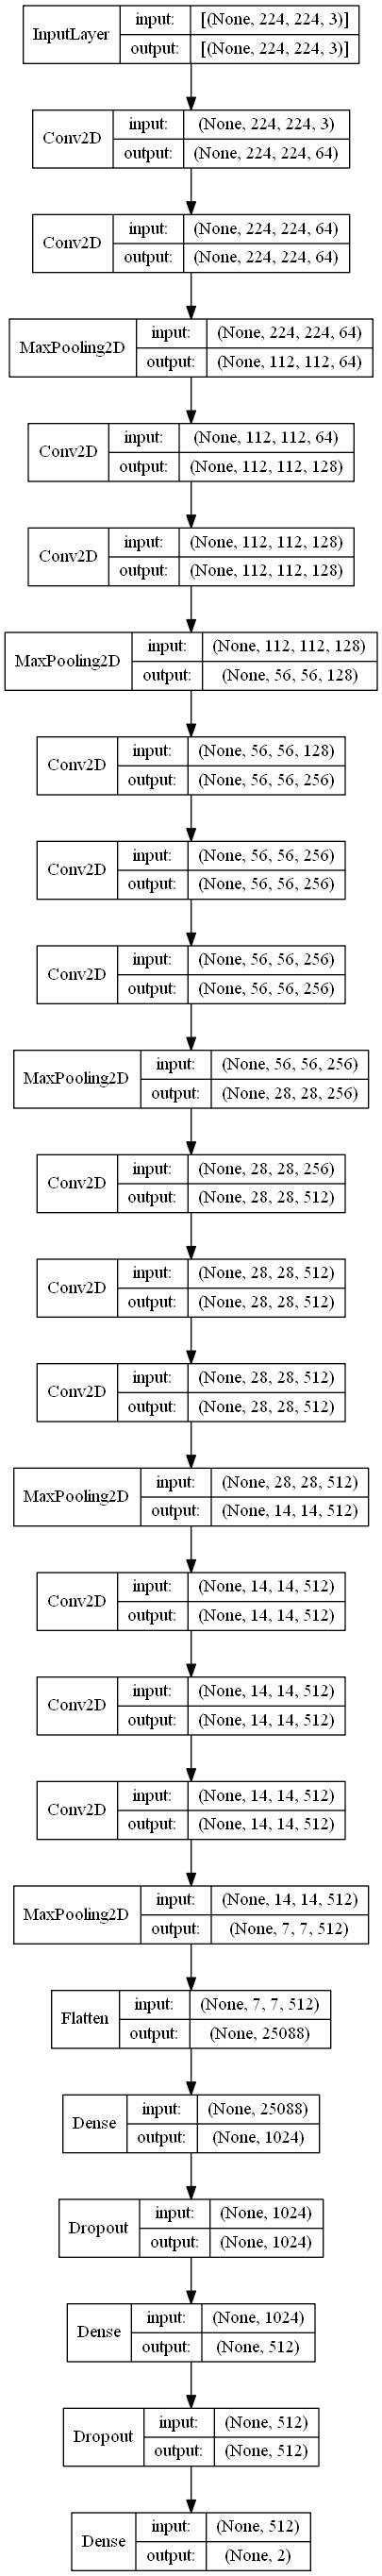

In [9]:
plot_model(
    model,
    to_file=os.path.sep.join([MODEL_PLOT, model.name+'.png']),
    show_shapes=True,
    show_layer_names=False
)

In [10]:
cp = ModelCheckpoint(
    MODEL_WEIGHT, 
    monitor='val_acc',
    save_best_only=True
)

In [11]:
tic = time.time()

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[cp],
    verbose=1
)

toc = time.time()

print('\n\ntraining speed = %.2f seconds' % (toc-tic))
print('training speed = %.2f minutes' % ((toc-tic)/60))

Epoch 1/100
7/7 [==============================] - 13s 2s/step - loss: 8.6201 - acc: 0.6062 - val_loss: 2.2784 - val_acc: 0.7800
Epoch 2/100
7/7 [==============================] - 1s 212ms/step - loss: 5.9906 - acc: 0.6788 - val_loss: 1.8386 - val_acc: 0.7000
Epoch 3/100
7/7 [==============================] - 3s 449ms/step - loss: 5.3997 - acc: 0.6736 - val_loss: 1.7632 - val_acc: 0.8600
Epoch 4/100
7/7 [==============================] - 2s 275ms/step - loss: 8.2904 - acc: 0.6943 - val_loss: 2.5668 - val_acc: 0.7600
Epoch 5/100
7/7 [==============================] - 2s 313ms/step - loss: 4.8129 - acc: 0.7565 - val_loss: 1.3307 - val_acc: 0.8600
Epoch 6/100
7/7 [==============================] - 2s 322ms/step - loss: 4.7027 - acc: 0.7668 - val_loss: 1.1200 - val_acc: 0.8600
Epoch 7/100
7/7 [==============================] - 2s 327ms/step - loss: 6.7831 - acc: 0.7565 - val_loss: 0.9662 - val_acc: 0.8400
Epoch 8/100
7/7 [==============================] - 5s 748ms/step - loss: 5.3263 - acc

7/7 [==============================] - 2s 308ms/step - loss: 0.8971 - acc: 0.9326 - val_loss: 0.5999 - val_acc: 0.9000
Epoch 64/100
7/7 [==============================] - 2s 324ms/step - loss: 0.5858 - acc: 0.9430 - val_loss: 0.7231 - val_acc: 0.9000
Epoch 65/100
7/7 [==============================] - 2s 307ms/step - loss: 0.4961 - acc: 0.9585 - val_loss: 0.8178 - val_acc: 0.9200
Epoch 66/100
7/7 [==============================] - 2s 300ms/step - loss: 0.4514 - acc: 0.9637 - val_loss: 0.7888 - val_acc: 0.9000
Epoch 67/100
7/7 [==============================] - 2s 305ms/step - loss: 1.0054 - acc: 0.9067 - val_loss: 0.8432 - val_acc: 0.9200
Epoch 68/100
7/7 [==============================] - 2s 318ms/step - loss: 0.8275 - acc: 0.9275 - val_loss: 0.8086 - val_acc: 0.9000
Epoch 69/100
7/7 [==============================] - 2s 330ms/step - loss: 0.3879 - acc: 0.9482 - val_loss: 0.9660 - val_acc: 0.9000
Epoch 70/100
7/7 [==============================] - 2s 342ms/step - loss: 4.2584 - acc: 0